In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda, Layer
from tensorflow.keras.models import Sequential
import pandas as pd

In [2]:
f = pd.read_hdf("events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")

In [19]:
print(f)

               pxj1         pyj1         pzj1         mj1      tau1j1  \
0      -1467.239990   611.502014   511.101990   38.896000    8.290650   
1      -1211.239990   347.315002   547.963013  389.532013  191.804001   
2      -1229.619995   649.857971     8.089170   72.155502   47.168098   
3       -693.304016 -1046.729980  1716.910034   55.797798   24.788500   
4      -1488.199951   -25.370100   -30.989700   84.891502   26.878799   
...             ...          ...          ...         ...         ...   
999994  -646.442017 -1295.150024  1331.800049   37.011299   21.006800   
999995  -286.550995 -1310.829956 -1510.910034  147.516998   60.997799   
999996   918.562988   951.195984 -1622.569946   32.242199    5.894110   
999997  1447.219971  -547.710999   827.945007  396.112000  181.406998   
999998   200.035995 -1252.869995    27.924900  363.790985  139.281998   

            tau2j1     tau3j1         pxj2         pyj2         pzj2  \
0         4.836080   4.260190  1403.579956  -674.55

In [6]:
G = (f[['pxj1','pxj2', 'pyj1', 'pyj2']]).to_numpy()
px1 = G[:, 0]
py1 = G[:, 2]
px2 = G[:, 1]
py2 = G[:, 3]


In [21]:
np.shape(px1)

(999999,)

(array([1.42000e+03, 4.67457e+05, 3.01060e+04, 4.00000e+01, 1.00000e+00,
        0.00000e+00, 2.40000e+01, 2.75780e+04, 4.71699e+05, 1.67400e+03]),
 array([-4.76285566, -3.81191235, -2.86096904, -1.91002573, -0.95908242,
        -0.00813911,  0.9428042 ,  1.89374751,  2.84469083,  3.79563414,
         4.74657745]),
 <a list of 10 Patch objects>)

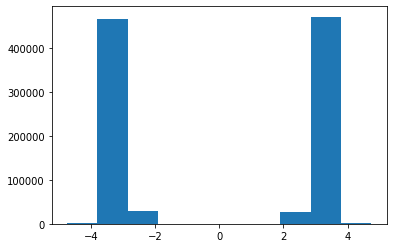

In [23]:
plt.hist(np.arctan2(G[:,2], G[:,0]) - np.arctan2(G[:,3], G[:,1]))

In [3]:
class MyLayer(Layer):

    def __init__(self, **kwargs):
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self._t1 = self.add_weight(name='x', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.RandomUniform(minval= 0, maxval=2*np.pi), #'uniform',
                                    trainable=True)
        self._t2 = self.add_weight(name='x', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=2*np.pi), #'uniform',
                                    trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, X):
        s1 = tf.math.sin(self._t1)
        c1 = tf.math.cos(self._t1)
        s2 = tf.math.sin(self._t2)
        c2 = tf.math.cos(self._t2)
        npc = [[c1, s1, 0.0, 0.0], [-s1, c1, 0.0, 0.0], [0.0, 0.0, c2, s2], [0.0, 0.0, -s2, c2]]
        M = tf.convert_to_tensor(npc)
        M = tf.reshape(M, [4, 4])
        return tf.linalg.matmul(X, M)

In [22]:
def define_discriminator(n_inputs=4):
	model = Sequential()
	model.add(Dense(25, activation='relu', input_dim=n_inputs))
	model.add(Dense(25, activation='relu', input_dim=n_inputs))    
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(n_outputs=1):
	#model = Sequential()
	#model.add(Dense(15, activation='relu', input_dim=n_outputs))
	#model.add(Dense(15, activation='relu', input_dim=n_outputs))    
	#model.add(Dense(n_outputs, activation='linear'))

	mymodel_inputtest = Input(shape=(4,))
	mymodel_test = MyLayer()(mymodel_inputtest)
	model = Model(mymodel_inputtest, mymodel_test)
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model
 
# generate n real samples with class labels
def generate_real_samples(n):
	randomlySelectedY = np.argsort(np.random.random(len(px1)))[:n]
	X = [px1[randomlySelectedY], py1[randomlySelectedY], px2[randomlySelectedY], py2[randomlySelectedY]]
	y = np.ones((n, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(n):
	# generate points in the latent space
	x_input = generate_real_samples(n)
	return x_input[0]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, n):
	# generate points in latent space
	x_input = generate_latent_points(n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y

def generate_fake_samples_with_input(generator, n):
	# generate points in latent space
	x_input = generate_latent_points(n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y, x_input
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, n_epochs=10000, n_batch=128, n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
#		if (i+1) % n_eval == 0:
#			print("epoch = ", i)

In [23]:
N = 1
t1i = []
t1f = []
t2i = []
t2f = []
for j in range(N):
    print("j = ", j)
    # create the discriminator
    discriminator = define_discriminator()
    # create the generator
    generator = define_generator()
    # create the gan
    gan_model = define_gan(generator, discriminator)
    t1i.append(generator.layers[-1].get_weights()[0][0])
    t2i.append(generator.layers[-1].get_weights()[1][0])

    # train model
    train(generator, discriminator, gan_model)
    t1f.append(generator.layers[-1].get_weights()[0][0])
    t2f.append(generator.layers[-1].get_weights()[1][0])
    
print("LHC Olympics")
print("t1i = ", t1i)
print("t2i = ", t2i)
print("t1f = ", t1f)
print("t2f = ", t2f)

j =  0


ValueError: in user code:

    <ipython-input-3-4895f62b4035>:24 call  *
        M = tf.convert_to_tensor(npc)
    /usr/common/software/tensorflow/gpu-tensorflow/2.2.0-py37/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1283 convert_to_tensor_v2  **
        as_ref=False)
    /usr/common/software/tensorflow/gpu-tensorflow/2.2.0-py37/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1341 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /usr/common/software/tensorflow/gpu-tensorflow/2.2.0-py37/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:1455 _autopacking_conversion_function
        return _autopacking_helper(v, dtype, name or "packed")
    /usr/common/software/tensorflow/gpu-tensorflow/2.2.0-py37/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:1374 _autopacking_helper
        converted_elem = _autopacking_helper(elem, dtype, str(i))
    /usr/common/software/tensorflow/gpu-tensorflow/2.2.0-py37/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:1391 _autopacking_helper
        return gen_array_ops.pack(elems_as_tensors, name=scope)
    /usr/common/software/tensorflow/gpu-tensorflow/2.2.0-py37/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py:6348 pack
        "Pack", values=values, axis=axis, name=name)
    /usr/common/software/tensorflow/gpu-tensorflow/2.2.0-py37/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /usr/common/software/tensorflow/gpu-tensorflow/2.2.0-py37/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:595 _create_op_internal
        compute_device)
    /usr/common/software/tensorflow/gpu-tensorflow/2.2.0-py37/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3327 _create_op_internal
        op_def=op_def)
    /usr/common/software/tensorflow/gpu-tensorflow/2.2.0-py37/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1817 __init__
        control_input_ops, op_def)
    /usr/common/software/tensorflow/gpu-tensorflow/2.2.0-py37/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1657 _create_c_op
        raise ValueError(str(e))

    ValueError: Shapes must be equal rank, but are 1 and 0
    	From merging shape 1 with other shapes. for '{{node my_layer_1/packed/0}} = Pack[N=4, T=DT_FLOAT, axis=0](my_layer_1/Cos, my_layer_1/Sin, my_layer_1/packed/0/2, my_layer_1/packed/0/3)' with input shapes: [1], [1], [], [].


In [4]:
!pwd

/global/u1/k/kdesai/SymmetryDiscovery/SymmetryGAN


In [5]:
!ls

'1-c*x.ipynb'	     O2PlottingLossFunctions.ipynb
 4GL2Plots.ipynb     O2Theta
 4GL2data.txt	     PlottingLoss2.ipynb
 4O2Slices	     PlottingLossFunctions_v2.ipynb
 6GL2Plots.ipynb     Z2PlottingLossFunctions.ipynb
 Augmentation	    'b + c*x.ipynb'
 Distributions	     b+cx_stats.ipynb
 LHCOlympics.ipynb   events_anomalydetection_DelphesPythia8_v2_qcd_features.h5
'O(2).ipynb'	     fSymmDiscovery
'O(2)stats.ipynb'


In [5]:
g = pd.read_hdf("4GL2data.txt")

ImportError: Missing optional dependency 'tables'.  Use pip or conda to install tables.

In [7]:
!pip install tables --user

  Using cached https://files.pythonhosted.org/packages/0f/cb/4097be890a773af95343389faa8c283b0d9ff606f144227a548461dcbdd5/tables-3.6.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8d/37/851139d750ed1d88754ff0f69b7bcf83e8a6464207007a9b4a54942302d4/numexpr-2.7.3-cp37-cp37m-manylinux2010_x86_64.whl
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


999999

array([ 5, 14, 11, 12,  7,  6,  1, 18, 15,  4])

In [21]:
generate_real_samples(50)

([array([  224.46600342,  1467.2800293 ,  -898.66601562,  -539.34802246,
          -328.59399414,   258.85198975, -1444.01000977,  -489.99200439,
          -936.73199463,  -106.9489975 ,  -362.08898926, -1106.93994141,
          -621.25      ,  1019.38000488, -2089.94995117,  -440.41699219,
           843.46899414,  1264.23999023,  -940.90100098,  1031.59997559,
         -1061.79003906, -1108.23999023,  -330.60198975,   200.9980011 ,
          -134.51199341, -1016.90002441,   376.0960083 ,  -697.61700439,
         -1192.44995117,  1320.82995605,  -899.45300293,  -530.02502441,
           523.01098633,   902.41497803, -1000.07000732, -1242.64001465,
           678.40698242,  -797.3369751 ,   325.2250061 ,  -907.51599121,
          1089.18994141,  -269.26400757,  -857.72998047, -1179.86999512,
         -1009.71002197,  1125.61999512,   596.75799561,   -41.22900009,
          -915.29699707,   360.03900146]),
  array([ 1709.32995605,  -263.6210022 ,   878.79498291,  1256.7800293 ,
        

In [11]:
np.argsort(np.random.random(10))[:4]

array([9, 5, 7, 1])

[-1145.82995605 -1313.5300293   1377.76000977 -1211.11999512
  1227.84997559   515.84802246  -319.79699707  -339.55999756
   397.21398926  1130.33996582  -988.75299072   917.29998779
   180.28399658 -1622.68994141   664.35601807  -245.28300476
 -1206.56005859   980.97198486  -764.48199463 -2102.39990234
 -1210.61999512  -138.19999695  -430.72799683  1255.57995605
  -807.190979    1170.18005371 -1317.7800293   -852.67797852
 -1539.06005859  -106.77300262   541.65197754  -460.68899536
  1529.2800293    760.13800049 -1079.22998047 -1160.64001465
 -1111.89001465  1281.         -1271.45996094   606.00201416
  -986.79602051  1205.20996094  1706.60998535 -1144.86999512
  1142.22998047 -1130.66003418   -97.2519989   -933.07202148
   -63.06489944  -987.76397705]
